In [89]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import glob, os
import sys

In [90]:
columns = ['YEAR','MONTH','DAY','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET','DATA_COL']
data = pd.read_csv('1.csv',names=columns)
data

,YEAR,MONTH,DAY,TEMP_HIG,TEMP_COL,AVG_TEMP,AVG_WET,DATA_COL
0,2015,2,1,1.9,-0.4,0.7875,75.000,907.177044
1,2015,2,2,6.2,-3.9,1.7625,77.250,747.835779
2,2015,2,3,7.8,2.0,4.2375,72.750,740.097015
3,2015,2,4,8.5,-1.2,3.0375,65.875,760.081199
4,2015,2,5,7.9,-3.6,1.8625,55.375,676.920858
...,...,...,...,...,...,...,...,...
573,2016,8,27,27.8,19.2,23.1375,63.875,405.774864
574,2016,8,28,29.9,16.1,23.3125,68.500,424.654201
575,2016,8,29,29.9,18.1,23.7125,62.500,440.166755
576,2016,8,30,29.3,16.9,23.3250,71.500,425.353283


In [91]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [92]:
from sklearn.preprocessing import MinMaxScaler
# 将数据归一化到0-1之间,无量纲化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['DATA_COL','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET']].values)


In [93]:
# 将时序数据转换为监督问题数据
reframed = series_to_supervised(scaled_data, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829,0.162730,0.177215,0.236842,0.636743
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160,0.204724,0.326582,0.298142,0.561587
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218,0.223097,0.245570,0.268421,0.446764
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043,0.207349,0.184810,0.239319,0.271399
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193,0.262467,0.222785,0.270279,0.315240
...,...,...,...,...,...,...,...,...,...,...
573,0.096006,0.632546,0.794937,0.748607,0.576200,0.046446,0.729659,0.762025,0.766254,0.413361
574,0.046446,0.729659,0.762025,0.766254,0.413361,0.057837,0.784777,0.683544,0.770588,0.490605
575,0.057837,0.784777,0.683544,0.770588,0.490605,0.067196,0.784777,0.734177,0.780495,0.390397
576,0.067196,0.784777,0.734177,0.780495,0.390397,0.058258,0.769029,0.703797,0.770898,0.540710


In [94]:
#删除无用的label数据
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193
...,...,...,...,...,...,...
573,0.096006,0.632546,0.794937,0.748607,0.576200,0.046446
574,0.046446,0.729659,0.762025,0.766254,0.413361,0.057837
575,0.057837,0.784777,0.683544,0.770588,0.490605,0.067196
576,0.067196,0.784777,0.734177,0.780495,0.390397,0.058258


In [95]:
#修改时间序列
reframed = reframed.values
train_data = reframed[:,:-1]
train_targets = reframed[:,-1]
train_X = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))

In [96]:
def build_model():
    model1 = Sequential()
    model1.add(LSTM(50, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model1.add(LSTM(25, activation='relu'))
    model1.add(Dense(1))
    model1.compile(loss='mean_squared_error', optimizer='rmsprop',metrics = ['mae'])
    return model1

In [97]:
# num_epochs = 50
# k = 4
# num_val_samples = len(train_data) // k
# all_mae_histories = []
# for i in range(k):
#  print('processing fold #', i)
#  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
#  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
#  partial_train_data = np.concatenate(
#  [train_data[:i * num_val_samples],
#  train_data[(i + 1) * num_val_samples:]],
#  axis=0)
#  partial_train_targets = np.concatenate(
#  [train_targets[:i * num_val_samples],
#  train_targets[(i + 1) * num_val_samples:]],
#  axis=0)
#  val_data = val_data.reshape(val_data.shape[0],1,val_data.shape[1])
#  partial_train_data = partial_train_data.reshape(partial_train_data.shape[0],1,partial_train_data.shape[1])
#  # partial_train_targets = partial_train_targets.reshape(partial_train_targets[0],1,partial_train_targets[1])
#  model = build_model()
#  history = model.fit(partial_train_data, partial_train_targets,
#  validation_data=(val_data, val_targets),
#  epochs=num_epochs, batch_size=1, verbose=0)
#  mae_history = history.history['val_mae']
#  all_mae_histories.append(mae_history)

In [98]:
# average_mae_history = [
#  np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [99]:
# import matplotlib.pyplot as plt
# plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
# plt.xlabel('Epochs')
# plt.ylabel('Validation MAE')
# plt.show()

In [100]:
model = build_model()
model.fit(train_X, train_targets, epochs=100, batch_size=32, verbose=2, shuffle=False)

Epoch 1/100
19/19 - 2s - loss: 0.0458 - mae: 0.1326 - 2s/epoch - 86ms/step
Epoch 2/100
19/19 - 0s - loss: 0.0378 - mae: 0.1121 - 23ms/epoch - 1ms/step
Epoch 3/100
19/19 - 0s - loss: 0.0330 - mae: 0.1058 - 24ms/epoch - 1ms/step
Epoch 4/100
19/19 - 0s - loss: 0.0302 - mae: 0.1065 - 22ms/epoch - 1ms/step
Epoch 5/100
19/19 - 0s - loss: 0.0286 - mae: 0.1091 - 24ms/epoch - 1ms/step
Epoch 6/100
19/19 - 0s - loss: 0.0278 - mae: 0.1113 - 22ms/epoch - 1ms/step
Epoch 7/100
19/19 - 0s - loss: 0.0272 - mae: 0.1127 - 24ms/epoch - 1ms/step
Epoch 8/100
19/19 - 0s - loss: 0.0268 - mae: 0.1133 - 21ms/epoch - 1ms/step
Epoch 9/100
19/19 - 0s - loss: 0.0263 - mae: 0.1133 - 21ms/epoch - 1ms/step
Epoch 10/100
19/19 - 0s - loss: 0.0259 - mae: 0.1131 - 21ms/epoch - 1ms/step
Epoch 11/100
19/19 - 0s - loss: 0.0254 - mae: 0.1126 - 21ms/epoch - 1ms/step
Epoch 12/100
19/19 - 0s - loss: 0.0249 - mae: 0.1120 - 21ms/epoch - 1ms/step
Epoch 13/100
19/19 - 0s - loss: 0.0244 - mae: 0.1112 - 22ms/epoch - 1ms/step
Epoch 14/

19/19 [==============================] - 0s 831us/step


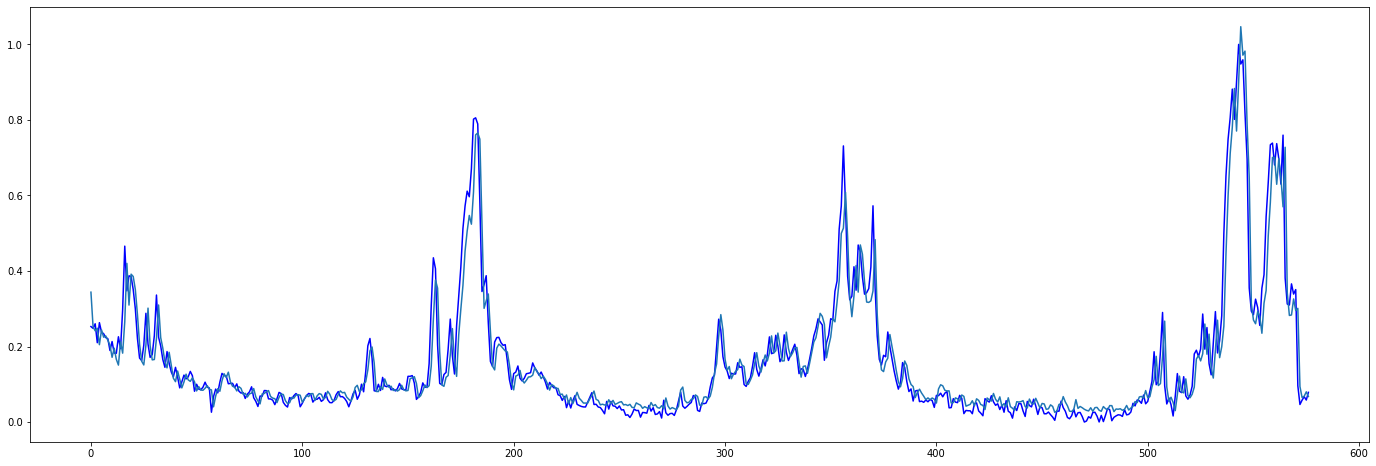

In [101]:
%matplotlib inline
plt.figure(figsize=(24,8))
train_predict = model.predict(train_X)
train_predict = np.array(train_predict).flatten()
# valid_predict = model.predict(valid_X)
# test_predict = model.predict(test_X)
plt.plot(train_targets, c='b')
plt.plot(train_predict)
# plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
# plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

In [102]:
train_predict.flatten()

array([0.34390974, 0.25237048, 0.24153575, 0.24837576, 0.20481567,
       0.2440465 , 0.22464551, 0.22799067, 0.21645771, 0.20349854,
       0.17139287, 0.1955937 , 0.16621785, 0.15078236, 0.21254446,
       0.18240851, 0.26569402, 0.42014503, 0.30971876, 0.3915478 ,
       0.3854557 , 0.35085112, 0.2846414 , 0.20608023, 0.16110744,
       0.15120079, 0.2033655 , 0.30166385, 0.20180221, 0.16461372,
       0.16560277, 0.22188748, 0.30992582, 0.22365259, 0.19553487,
       0.15933649, 0.14343789, 0.18469815, 0.14951631, 0.11602226,
       0.10695474, 0.13503928, 0.11350356, 0.0903738 , 0.10588895,
       0.12672465, 0.11178454, 0.10768119, 0.11703493, 0.1065518 ,
       0.08241306, 0.09389312, 0.08475426, 0.08404423, 0.08949324,
       0.09655206, 0.08662509, 0.08506221, 0.04030012, 0.06871162,
       0.08825541, 0.08153327, 0.1092189 , 0.12780723, 0.11797027,
       0.13204375, 0.10613494, 0.09475871, 0.092765  , 0.08240838,
       0.09361151, 0.08911411, 0.07339191, 0.07598232, 0.06624